In [2]:
%matplotlib inline

In [63]:
import pandas as pd
import nose.tools
import datetime
import wget
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy.stats as stats
# Write your imports here

# DUST BUSTER (Working Name)
## A Local Study for Air Pollution in Sofia City.

### DATA SELECTION

DATA SELECTION.
The database of the Luftdaten project is publicly available on the web and offers directory listing. The archive contains CSV dumps of all outdoor sensors that seem to have delivered valid data to the API. The data is organised in directories for each day, containing csv files for each sensor. For the past four years there are more than 1400 folders for each day. The first folder contains only 7 csv files for each sensor and by Aug. 2019 the folder contains thousands csv files. Therefore, the preffered approach is first to pre-select the sensors which will be included in the study and afterwards to download only those sensors’  data. The criteria for data selection is sensor’s location, data stability and period of measurement. 
The file to be used for sensor selections is a combined monthly data file "2019-07_sds011.csv" which contains monthly data for all sensors worldwide with size 9.94 GB and contains roughly 16*10pow7 rows (sensor measurements).

DATA VARIABLES<br>
<br>sensor_id – unique numeric reference to the sensor 
<br>sensor_type – SDS011/PPD42NS
<br>location - unique numeric reference to the location
<br>lat- latitude
<br>lon- longitude 
<br>timestamp- server date,time in UTC. For Bulgaria 3 hours must be added during summer time  and 2 hours during winter time
<br>P1 – absolute measurement of PM10 particles on the order of 10 micrometers or less. Also referred as coarse particulate matter.
<br>durP1 – time span during which the sensor measured zero measured P1. 
<br>ratioP1 – the ratio of durP1 to the duration of the measurement cycle (in this case the measurement cycle is 30 seconds)
<br>P2 – absolute measurement of PM2.5 particles on the order of 2.5 micrometers or less. Also referred as fine particulate matter.
<br>durP2 – time span during which the sensor measured zero measured P2. 
<br>ratioP2 - the ratio of durP2 to the duration of the measurement cycle (in this case the measurement cycle is 30 seconds)

First we define a function to select sensors located within Sofia. The file is opened in chunks, the filter function is applied and the new dataframe is saved droping the duplicate sensor ids.

In [ ]:
def apply_criteria(df):
    MAX_LAT = 42.75 # Sofia city is better described as circular rather than a rectangular area. For the sake of simplicity our filter is a rectange.
    MIN_LAT = 42.64
    MAX_LON = 23.42
    MIN_LON = 23.23
    selected = df[(df.lat <= MAX_LAT)&(df.lat >= MIN_LAT)&(df.lon <= MAX_LON)&(df.lon >= MIN_LON)]
    return selected

In [ ]:
# Remark: the csv is not included in the package (size 9.94 GB).It can be downloaded from https://archive.luftdaten.info/csv_per_month/2019-07/
chunk_list = []
for chunk in pd.read_csv("2019-07_sds011.csv",chunksize=100000,sep=";",usecols = ['sensor_id','lat','lon']):
    chunk_filtered = apply_criteria(chunk) # we apply the location criteria to filter only sensors in Sofia
    chunk_list.append(chunk_filtered)
df_concat = pd.concat(chunk_list)
df_concat = df_concat.drop_duplicates(subset='sensor_id', keep="first")
df_concat.to_csv('df_concat4.csv')
print(df_concat.shape)

From the initial monthly conglomerated file of 9.94 GB we have succeeded to create a 12 KB csv file containing 317 rows representing unique sensors in Sofia. Next step is to search recursively the 1400 folders in the Luftdaten web archive and to extract files refering to the 317 selected sensors. Luckily, the folder names (urls names) and the file names have a pattern that can be easily generated with datetime and loops. 

In [ ]:
# Remark: the script requires large space on disk (5+ GB) and more than 3 hours running.
sensor_list = df_concat.sensor_id.tolist() # list of 317 sensors in Sofia

start_date = date(2015, 10, 1)   # start date
end_date = date(2019, 7, 31)   # end date

delta = end_date - start_date       # as timedelta

for day in range(delta.days + 1):
    day = start_date + timedelta(days=day)
    for sensor in sensor_list:
        urlfolder = "http://archive.luftdaten.info/" + str(day) + "/" + str(day) + "_sds011_sensor_"+str(sensor)+".csv"
        destination = "C:/Users/Ynche/Downloads/DBuster/" + str(day) + "_sds011_sensor_"+str(sensor)+".csv"
        try:
            wget.download(urlfolder, destination)
        except:
            continue

We succeeeded to extract 139,204 csv files. Each csv file represents the measurements captured by one sensor for one day. People have been adopting sensors gradually therefore, the number of operating sensors have been increasing over time. In each file the number of observations varies. Sensors have different settings and some are taking measurements every minute, others every 2.5 minutes and for some sensors parts of the day is missing. Ideally, the data should be uniform through space and time and we should use the same sensors for the same period of time measuring the same part of the day.
<br> In order to make a preselection of sensors that will be included in the study, we will extract from all files information about each sensor_id, observation date and number of observations.
<br> DATA IN THE PRESELECTION FILE
<br> sensor_id - unique numeric reference to the sensor 
<br> date - observation date
<br> observations - count of number of observations, grouped by the hour (average). Eg. a sensor might take measures every minute or every 3 minutes, but if it works without intermission, there will be 24 observation per day (ultimatelly we are interested by the average per hour).

In [ ]:
# Remark: the script requires files from previous step to be downloaded first. We create one row per sensor from the 
# 317 sensors in Sofia containing info about date and number of hourly observations.
os.chdir('C:/Users/Ynche/Downloads/DBuster')
summary_df = pd.DataFrame(columns=['sensor_id', 'date', 'observations','lon','lat'])
for file in os.listdir(os.getcwd()):
    if file.endswith('.csv'):
        df = pd.read_csv(file, sep=";")
        df['dtime'] = pd.to_datetime(df.timestamp)
        new_df = pd.DataFrame()
        new_df["P1"] = df.set_index('dtime').resample('H')['P1'].mean().round(2)# P1 hourly average
        new_df["P2"] = df.set_index('dtime').resample('H')['P2'].mean().round(2)# P2 hourly average
        summary_df = summary_df.append({'sensor_id': df.sensor_id[0], 'date': df.dtime.dt.date[0], 'observations': new_df.shape[0],'lon':df.lon[0],'lat':df.lat[0]}, ignore_index=True)
summary_df.to_csv('Agglomerated/summary2.csv')


In [4]:
raw_summary = pd.read_csv("summary2.csv") 
raw_summary['date'] = pd.to_datetime(raw_summary['date'])
raw_summary.groupby('date')["sensor_id"].count().head(5)

date
2017-02-22    1
2017-02-23    1
2017-02-24    1
2017-02-25    1
2017-02-26    2
Name: sensor_id, dtype: int64

In [ ]:
raw_summary.groupby('date')["sensor_id"].count().tail(5)

In [76]:
def plot_observations_by_month(df):
    new_df =  df.groupby(pd.Grouper(key='date',freq='M'))["sensor_id"].count()
    new_df.plot(kind='bar',x='date',y=new_df[1])
    plt.xticks(range(len(new_df.index)),new_df.index.strftime("%Y-%m"))
    plt.xlabel("Month")
    plt.ylabel("Number of Daily Observations")
    return plt.show()
    

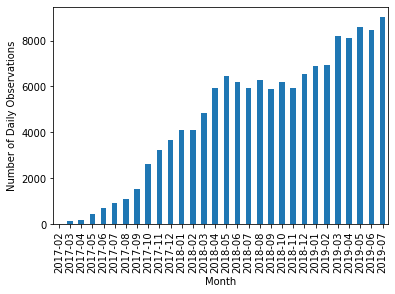

In [79]:
plot_observations_by_month(raw_summary)

The first two sensors appear in Sofia on February 2017 and by July 2019 there are around 300 sensors. Plotting the data shows that there has been a steep increase rate of the set up of new sensors until April 2018, followed by a decline of the increase rate between April 2018 and March 2019. 

In [ ]:
raw_summary.head(5)

When choosing the right sample to be included in a panel reasearch study, there is a trade off between the preference for longer time series data against the preference for more cross section observations. In case the study is targeted at investigating time changes (eg. seasonal, monthly) the reasearcher might choose to include less sensors but for longer period of time and if the reaserch is spatially oriented, vice versa. Lets choose for now the starting time of the study to be October 2017. We will select sensors that have been in operation since October and have been working without large intermissions until July 2019.

In [6]:
# from the initial list of 317 sensors we check which one of them operated in October 2017
summary = raw_summary.groupby(pd.Grouper(key='date',freq='M'))["sensor_id"].unique()
sensor_list = summary.filter(like='2017-10', axis=0).tolist() 
sensor_list[0].size

103

In [59]:
raw_summary.head(5)

,Unnamed: 0,sensor_id,date,observations,lon,lat
0,0,739,2017-02-22,6,23.337,42.694
1,1,739,2017-02-23,24,23.337,42.694
2,2,739,2017-02-24,24,23.337,42.694
3,3,739,2017-02-25,24,23.337,42.694
4,4,739,2017-02-26,24,23.337,42.694


In [82]:
# we remove the 214 sensors (317-103) and remove dates outside the selected period 10.2017 till 07.2019
new_summary = raw_summary[raw_summary.sensor_id.isin(sensor_list[0])]
new_summary = new_summary[~new_summary['date'].isin(pd.date_range(start='20150101', end='20170930'))]
new_summary.shape

(61973, 6)

In [ ]:
(61973, 6)

In [ ]:
new_summary.head(5)

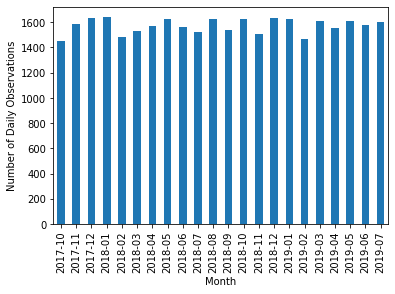

In [78]:
plot_observations_by_month(new_summary)

In [90]:
def hist_sensor_observations(df):
    new_df = df.groupby('sensor_id')['observations'].count()
    plt.hist(new_df,bins=20)
    plt.xlabel("Number of Daily Observations")
    plt.ylabel("Number of Sensors")
    return plt.show()
    

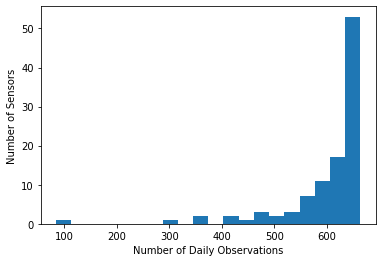

In [91]:
hist_sensor_observations(new_summary)

In [10]:
reduced_summary = df[df>=635] # selection of sensors with more than 95% daily completeness of observations
remaining_summary = df[df<635] # remaining sensors later to be plotted
reduced_summary.shape

(53,)

In [11]:
reduced_sensor_list = reduced_summary.index.tolist()
remaining_sensor_list = remaining_summary.index.tolist()

Until current stage, we have succeeded to select 53 sensors located in Sofia that have more than 95% completedness of daily observation data (635 out of 668). Plotting the hourly completeness of data shows that most of the sensors, for most of the data, have taken at least one measurement for every hour of the day (remember that we have abveraged measurements by the hour). In fact 96% of observations have all 24 hourly averages. However, the missing data is widely dispersed among sensors. If we set up a minimum treshhold of 8 hourly averages we would have to remove 42 sensors that have at least one measurement with missing hourly data.

In [12]:
new_summary = new_summary[new_summary.sensor_id.isin(reduced_sensor_list)]
new_summary.shape

(34589, 6)

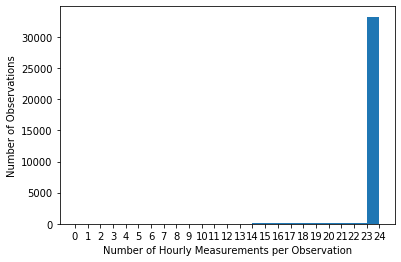

In [13]:
plt.hist(new_summary['observations'],range=[0, 24],bins = 24)
plt.xlabel("Number of Hourly Measurements per Observation")
plt.xticks(range(25))
plt.ylabel("Number of Observations")
plt.show()

In [14]:
new_reduced_summary = new_summary[new_summary.observations==24]
new_reduced_summary.shape

(33038, 6)

In [15]:
check_summary = new_summary[new_summary.observations<8] # we check that 42 sensors have at least 1 day with less than 8 hourly observations
check_list = check_summary.sensor_id.unique().tolist()
len(check_list)

42

Clearly, missing hourly data is widely dispersed among sensors, meaning that most of the sensors have just several missing hourly data observations. There is one clear outlier - sensor 6227 has 277 daily observations that do not meet the 24 hour requirement, meaning that it has only 69% complete data and we can remove the sensor from the final list. Later, when we inspect the measurments of P1 and P2 we will see that for some observations measurements for P1 and P2 are missing within observations.

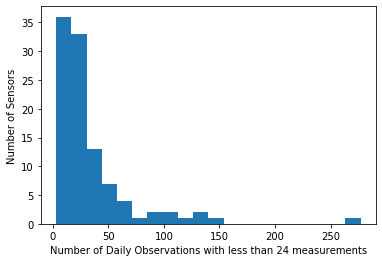

In [86]:
missing_data = new_summary[new_summary.observations<24]
df = missing_data.groupby('sensor_id')["observations"].count()
plt.hist(df,bins=20)
plt.xlabel("Number of Daily Observations with less than 24 measurements")
plt.ylabel("Number of Sensors")
plt.show()

In [17]:
df.idxmax()

6227

In [17]:
reduced_sensor_list.remove(6227)
len(reduced_sensor_list)

52

In [53]:
reduced_sensor_list

[1102,
 1304,
 1471,
 2039,
 2888,
 3095,
 3191,
 3435,
 3619,
 3633,
 3641,
 3759,
 3831,
 3835,
 4357,
 4466,
 4474,
 4607,
 5293,
 5295,
 5297,
 5299,
 5377,
 5379,
 5471,
 5499,
 5513,
 5527,
 5565,
 5662,
 5690,
 5708,
 5807,
 5878,
 5888,
 6023,
 6029,
 6041,
 6095,
 6131,
 6133,
 6139,
 6149,
 6223,
 6342,
 6344,
 6388,
 6392,
 6434,
 6463,
 6465,
 6529]

After plotting the sensors on Sofia map in red, the selected 52 sensors seem randomly dispersed. However, the north-west part of Sofia is highly underrepresented as well as the south-east part. The districst of Lylin and Mladost (NW) have almost no sensors selected at all and Mladost and Drujba (SE) have just several. In order to investigate the selection bias all sensors launched after October 2017 are plotted in orange and the sensors excluded due to the 95% treshold criteria are plotted in blue. Indeed, it seems that generally sensors in NW and SE part of the city are being launched later than October 2017. Reasons might be that people living near Vitosha mountain and city center are more interested in the quality of air, or they might be early adopters due to age or education, or they have higher income and can aford maintaining a sensor, or higher population density in these area or some other.

<br>- red dots - 52 selected sensors
<br>- blue dots - remaining 51 sensors which were not included in the study because they did not meet the 95% treshold of daily completedness of observations
<br>- orange dots - sensors that were launched after October 2017 and therefore were not included in the study

In [18]:
sensors_plot_all = raw_summary.drop_duplicates(subset ="sensor_id", keep = 'first') 
sensors_plot_excluded = sensors_plot_all[~sensors_plot_all.sensor_id.isin(reduced_sensor_list)]
sensors_plot_selected = sensors_plot_all[sensors_plot_all.sensor_id.isin(reduced_sensor_list)]
sensors_plot_excluded_after_oct2017 = sensors_plot_excluded[~sensors_plot_excluded.sensor_id.isin(remaining_sensor_list)]
sensors_plot_excluded_before_oct2017 = sensors_plot_excluded[sensors_plot_excluded.sensor_id.isin(remaining_sensor_list)]

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=5396678.654313799,2264763.803776418,5426957.138535508,2282615.9353498523&bboxSR=3035&imageSR=3035&size=7000,4127&dpi=1000&format=png32&transparent=true&f=image


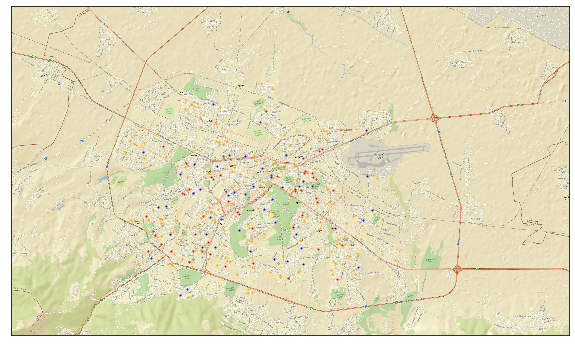

In [19]:
m = Basemap(resolution='i',llcrnrlat = 42.64, llcrnrlon = 23.15, urcrnrlat = 42.75, urcrnrlon = 23.55,epsg=3035)
plt.figure(figsize=[10,20])
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 7000, dpi=1000,verbose= True)
# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 3500, dpi=500,verbose= True) #The street view oulines better the red sensors
x, y = m(sensors_plot_selected.lon.tolist(), sensors_plot_selected.lat.tolist())
z, v = m(sensors_plot_excluded_before_oct2017.lon.tolist(), sensors_plot_excluded_before_oct2017.lat.tolist())
q, r = m(sensors_plot_excluded_after_oct2017.lon.tolist(), sensors_plot_excluded_after_oct2017.lat.tolist())
m.plot(x, y, "o", markersize = 1, color = "red")
m.plot(z, v, "o", markersize = 1, color = "blue")
m.plot(q, r, "o", markersize = 1, color = "orange")
# plt.show()
plt.savefig('SofiaStreetMap5.png',bbox_inches="tight")

Before further extracting and investigating data we should acknowledge the numerical and scientific quality of the data 
<br>Figures & Facts
- 52 sensors selected within the area of Sofia 
- The period selected is from 01.10.2017 untill 31.07.2019 (668 days). Maximum theoretical number of hourly observations would be 833,664.
- Number of recorded hourly observations: 804,243. For 6,235 from those observations, the hourly data for P1 and P2 is missing (null). There are 23,186 hourly observations not recorded at all. 

<br>Positive:
<br> Shortcomings:
Sensor selection:
1. Sensor selection is framed by coordinates that neither represent the natural circular shape of Sofia, nor the 24 formal administrative city districts. Geographical selection relies on the investigator's criteria for rectangular selection of Sofia area. The gains of more realistic geographical filter selection do not outweght the cost of spending the efforts to creating a complicated filter.
2. Sensor selection is highly biased towards sensors that have complete observations without intermissions. Imagine that sensors with complete observations tend to belong to people that are rich and can pay the bills for the electricity and therefore sensors do not break up due to electricity stopages. Imagine that rich people tend to live in expensive districts away from production facilities where the air is cleaner than the poor districts. The selection bias might imply that the average level of polution recorded by all selected sensors will record lower levels than the reality.

We have selected 52 sensors  from 10.2017 until 07.2019 including and we can  start with the analysis of the polution.

In [ ]:
# Remark: the script requires that the database is downloaded first.
os.chdir('C:/Users/Ynche/Downloads/DBuster')
sensors_df = pd.DataFrame()
for file in os.listdir(os.getcwd()):
    index = file.rfind('_')
    if file.endswith('.csv') and int(file[index+1:-4]) in reduced_sensor_list:
        df = pd.read_csv(file, sep=";")
        df['dtime'] = pd.to_datetime(df.timestamp)
        new_df = pd.DataFrame()
        new_df["P1"] = df.set_index('dtime').resample('H')['P1'].mean().round(2)
        new_df["P2"] = df.set_index('dtime').resample('H')['P2'].mean().round(2)
        new_df["sensor_id"] = df.sensor_id[0]
        new_df["sensor_type"] = df.sensor_type[0]
        new_df["location"] = df.location[0]
        new_df["lat"] = df.lat[0]
        new_df["lon"] = df.lon[0]
        sensors_df = pd.concat([sensors_df,new_df])
sensors_df.to_csv('Agglomerated/sensors_df.csv')

In [19]:
sensors_df = pd.read_csv("sensors_df.csv") 
sensors_df.dtime = pd.to_datetime(sensors_df.dtime)
sensors_df['date'] = sensors_df.dtime.dt.date
sensors_df['date'] = pd.to_datetime(sensors_df.date)
sensors_df['hour'] = sensors_df.dtime.dt.hour
sensors_df['weekday'] = sensors_df.dtime.dt.weekday
sensors_df['weekdayname'] = sensors_df.dtime.dt.weekday_name
sensors_all=sensors_df[~sensors_df.date.isin(pd.date_range(start='20150101', end='20170930'))]
sensors_all.shape

(804243, 12)

In [20]:
sensors_all.dtypes

dtime          datetime64[ns]
P1                    float64
P2                    float64
sensor_id               int64
sensor_type            object
location                int64
lat                   float64
lon                   float64
date           datetime64[ns]
hour                    int64
weekday                 int64
weekdayname            object
dtype: object

In [75]:
sensors_all.head(5)

,dtime,P1,P2,sensor_id,sensor_type,location,lat,lon,date,hour,weekday,weekdayname
55166,2017-10-01 00:00:00,8.85,6.16,1102,SDS011,538,42.655,23.376,2017-10-01,0,6,Sunday
55167,2017-10-01 01:00:00,8.97,6.30,1102,SDS011,538,42.655,23.376,2017-10-01,1,6,Sunday
55168,2017-10-01 02:00:00,9.89,6.74,1102,SDS011,538,42.655,23.376,2017-10-01,2,6,Sunday
55169,2017-10-01 03:00:00,10.35,7.10,1102,SDS011,538,42.655,23.376,2017-10-01,3,6,Sunday
55170,2017-10-01 04:00:00,12.05,8.15,1102,SDS011,538,42.655,23.376,2017-10-01,4,6,Sunday


In [22]:
sensors_all.isnull().sum()

dtime             0
P1             6235
P2             6235
sensor_id         0
sensor_type       0
location          0
lat               0
lon               0
date              0
hour              0
weekday           0
weekdayname       0
dtype: int64

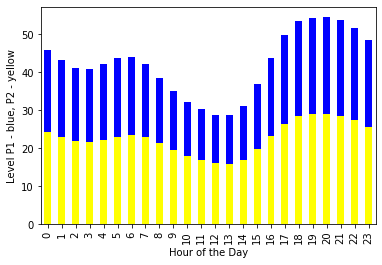

In [24]:
average_p1 = sensors_all.groupby('hour')["P1"].mean()
average_p2 = sensors_all.groupby('hour')["P2"].mean()
average_p1.plot(kind='bar',x='hour',y=['P1'],color='blue', align='center')
average_p2.plot(kind='bar',x='hour',y=['P2'],color='yellow', align='center')
plt.xlabel("Hour of the Day")
plt.ylabel("Level P1 - blue, P2 - yellow")
plt.show()

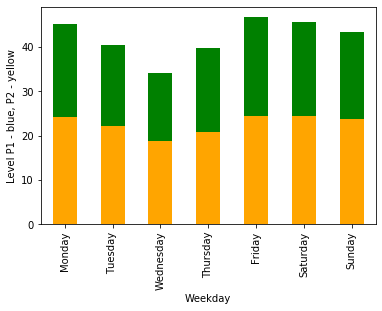

In [25]:
average_p1 = sensors_all.groupby('weekday')["P1"].mean()
average_p2 = sensors_all.groupby('weekday')["P2"].mean()
average_p1.plot(kind='bar',x='weekday',y=['P1'],color='green', align='center')
average_p2.plot(kind='bar',x='weekday',y=['P2'],color='orange', align='center')
# plt.xticks(range(6),list(sensors_all.weekdayname))
plt.xticks(range(7),('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))
plt.xlabel("Weekday")
plt.ylabel("Level P1 - , P2 - ")
plt.show()

Finally, the independent variable is obtained and we can explore for dependencies with external factors. Possible relationships are:
<br> Day of the week - there should be less polution during the weekend due to lower traffic and less production activities
<br> Summer holiday period - less polution due to less traffic
<br> Heating period - less polution during non winter days due to less heat energy consumption. In Bulgaria 100% of state heat energy is produced in thermal power stations In Sofia there are 2 TPS that use natural gas. However, many households in the suburban part use coal and wood for heating.


The National Climatic Data Center of the US Department of Commerce provides an archive of worldwide meteorological stations measurements. The database includes three stations for Sofia - two in Vrajdebna on the premises of the airport and one in the observatory near Sofia.
DATA VARABLES
<br> STN - Station number (WMO/DATSAV3 number) for the location. 156140 for Sofia.
<br> YEARMODA - date 
<br> TEMP - Mean temperature for the day in degrees Fahrenheit
<br> DEWP - Mean dew point for the day in degrees Fahrenheit to tenths.  Missing = 9999.9
<br> SLP - Mean sea level pressure for the day in millibars.
<br> STP - Mean station pressure for the dayin millibars 
<br> VISIB - Mean visibility for the day in miles
<br> WDSP - Mean wind speed for the day in knots
<br> MXSPD -Maximum sustained wind speed reported for the day in knots
<br> GUST - Maximum wind gust reported for the day in knots
<br> MAX - Maximum temperature reported during the day in Fahrenheit
<br> MIN - Minimum temperature reported during the day in Fahrenheit
<br> PRCP - Total precipitation (rain and/or melted snow) reported during the day in inches
<br> SNDP - Snow depth in inches to tenths--last report for the day if reported more than once.
<br> FRSHTT - Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day of:
                         <br>   Fog ('F' - 1st digit).
                         <br>   Rain or Drizzle ('R' - 2nd digit).
                         <br>   Snow or Ice Pellets ('S' - 3rd digit).
                         <br>   Hail ('H' - 4th digit).
                         <br>   Thunder ('T' - 5th digit).
                         <br>   Tornado or Funnel Cloud ('T' - 6th digit).

In [21]:
climate_data = pd.read_csv('NOAA station 156140.txt', sep=",",usecols=[" YEARMODA", "   TEMP", "  WDSP",'  STP  '])
climate_data.columns=climate_data.columns.str.strip()
climate_data.TEMP = round((climate_data.TEMP-32)*5/9,1) # convert to Celsius
climate_data['date'] = pd.to_datetime(climate_data.YEARMODA,format='%Y%m%d').dt.date
climate_data['date'] = pd.to_datetime(climate_data.date) # include date in datetime format

In [24]:
climate_data.head(5)

,YEARMODA,TEMP,STP,WDSP,date
0,20151001,12.4,9999.9,4.0,2015-10-01
1,20151002,11.6,9999.9,3.9,2015-10-02
2,20151003,13.4,9999.9,2.7,2015-10-03
3,20151004,15.3,9999.9,2.2,2015-10-04
4,20151005,17.1,9999.9,3.4,2015-10-05


In [22]:
climate_data.dtypes

YEARMODA             int64
TEMP               float64
STP                float64
WDSP               float64
date        datetime64[ns]
dtype: object

In [96]:
climate_data.isnull().sum()

YEARMODA    0
TEMP        0
STP         0
WDSP        0
date        0
dtype: int64

In [111]:
climate_data.TEMP.max()

30.0

In [112]:
climate_data.TEMP.min()

-14.8

In [23]:
sensors_all_with_temp = pd.merge(left=sensors_all,right=climate_data, how='left', left_on='date', right_on='date')

In [26]:
sensors_all_with_temp.head(5)

,dtime,P1,P2,sensor_id,sensor_type,location,lat,lon,date,hour,weekday,weekdayname,YEARMODA,TEMP,STP,WDSP
0,2017-10-01 00:00:00,8.85,6.16,1102,SDS011,538,42.655,23.376,2017-10-01,0,6,Sunday,20171001.0,11.6,9999.9,6.6
1,2017-10-01 01:00:00,8.97,6.30,1102,SDS011,538,42.655,23.376,2017-10-01,1,6,Sunday,20171001.0,11.6,9999.9,6.6
2,2017-10-01 02:00:00,9.89,6.74,1102,SDS011,538,42.655,23.376,2017-10-01,2,6,Sunday,20171001.0,11.6,9999.9,6.6
3,2017-10-01 03:00:00,10.35,7.10,1102,SDS011,538,42.655,23.376,2017-10-01,3,6,Sunday,20171001.0,11.6,9999.9,6.6
4,2017-10-01 04:00:00,12.05,8.15,1102,SDS011,538,42.655,23.376,2017-10-01,4,6,Sunday,20171001.0,11.6,9999.9,6.6


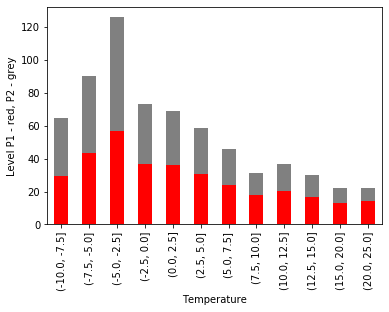

In [27]:
bins= [-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15,20,25]
average_p1_by_temp = sensors_all_with_temp.groupby(pd.cut(sensors_all_with_temp.TEMP,bins=bins))["P1"].mean()
average_p2_by_temp = sensors_all_with_temp.groupby(pd.cut(sensors_all_with_temp.TEMP,bins=bins))["P2"].mean()
average_p1_by_temp.plot(kind='bar',x='TEMP',y=['P1'],color='gray', align='center')
average_p2_by_temp.plot(kind='bar',x='TEMP',y=['P2'],color='red', align='center')
# plt.xticks(range(6),list(sensors_all.weekdayname))
# plt.xticks(range(7),('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))
plt.xlabel("Temperature")
# plt.xticks(rotation= 'horizontal')
plt.ylabel("Level P1 - red, P2 - grey")
plt.show()

In [24]:
def season(temperature):
    if temperature <= 10:
        return 'cold'
    else:
        return 'warm'

In [25]:
sensors_all_with_temp['weather'] = sensors_all_with_temp['TEMP'].apply(season).astype('category')

In [ ]:
sensors_all_with_temp.dtypes

In [33]:
def average_pollution(dataframe,indicator,season):
    df = dataframe[dataframe.weather == season]
    pollution = df[indicator].mean()
    return pollution

In [34]:
average_pollution(sensors_all_with_temp,'P1','cold')

61.17428267900373

In [35]:
average_pollution(sensors_all_with_temp,'P1','warm')

25.732569252872878

In [36]:
average_pollution(sensors_all_with_temp,'P2','cold')

31.240400191734427

In [37]:
average_pollution(sensors_all_with_temp,'P2','warm')

15.163464506950483

In [50]:
def seasonal_difference_barchart(indicator):
    df1 = sensors_all_with_temp[sensors_all_with_temp.weather =='cold'].groupby('hour')[indicator].mean()
    df2 = sensors_all_with_temp[sensors_all_with_temp.weather =='warm'].groupby('hour')[indicator].mean()
    df1.plot(kind='bar',x='hour',y=[indicator],color='blue', align='center')
    df2.plot(kind='bar',x='hour',y=[indicator],color='orange', align='center')
    plt.xlabel("Hour of the Day")
    plt.ylabel("{} Warm days: orange, Cold days - blue".format(indicator))
    return plt.show()

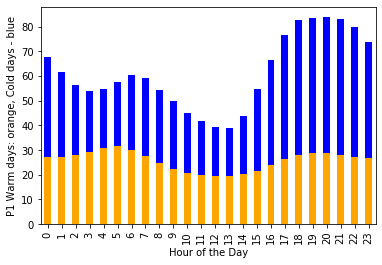

In [51]:
 seasonal_difference_barchart('P1')

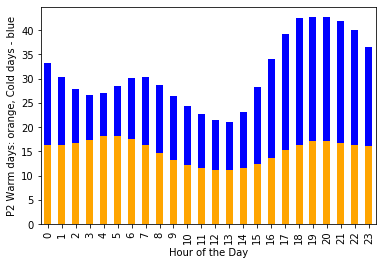

In [52]:
 seasonal_difference_barchart('P2')

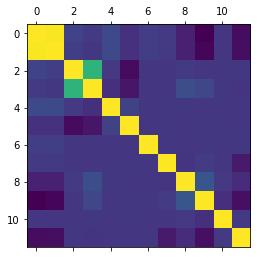

In [54]:
plt.matshow(sensors_all_with_temp.corr())
plt.show()

In [59]:
def correlation_matrix(dataframe, *args): 
    new_df = dataframe[[*args]].copy()
    corr = new_df.corr()
    return corr.style.background_gradient(cmap='coolwarm')

In [62]:
correlation_matrix(sensors_all_with_temp,"P1","P2","TEMP","WDSP")

,P1,P2,TEMP,WDSP
P1,1,0.990116,-0.190682,-0.15016
P2,0.990116,1,-0.169979,-0.145361
TEMP,-0.190682,-0.169979,1,-0.143721
WDSP,-0.15016,-0.145361,-0.143721,1


In [70]:
def anova_hour(df):
    df["hour"] = df["hour"].astype('category')
    F, p = stats.f_oneway(df[df.hour=='1'].P1,
                      df[df.hour=='2'].P1,
                      df[df.hour=='3'].P1)
    return F

    

In [71]:
anova_hour(sensors_all_with_temp)

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:3219: RuntimeWarning: Mean of empty slice.
  offset = alldata.mean()
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:3222: RuntimeWarning: invalid value encountered in double_scalars
  sstot = _sum_of_squares(alldata) - (_square_of_sums(alldata) / bign)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:3225: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:3229: RuntimeWarning: invalid value encountered in double_scalars
  ssbn -= _square_of_sums(alldat

nan

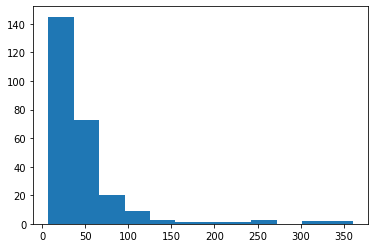

In [105]:
average_p1_by_temp = sensors_all_with_temp.groupby('TEMP')["P1"].mean()
average_p2_by_temp = sensors_all_with_temp.groupby('TEMP')["P2"].mean()
plt.hist(average_p1_by_temp,bins=12)
plt.show()